# CANSOFCOM Machine Learning for Drone Identification




## Dependencies:
* scipy
* numpy
* pytorch
* matplotlib
* scikit-learn

all of them are classics for this type of project.

## 1 Time-Domain Radar Return Signals
Let's start with defining our symbols. There are a lot.
### Drone parameters
$N$: The number of blades in a single rotor. Almost always 2. For now, we're not considering multi-rotor drones  
$f_{rot}$: (1/s) the frequency of rotation of the rotor. This is drone-dependent, but could be \[50, 18\]  
$L_1$: (meters) The distance of the blade roots from the center of rotation of the rotor. For now, assumed to be 0.  
$L_2$: (meters) The distance of the blade tips from the center of rotation of the rotor. Differs depending on drone, generally 0.05 to 0.25.  

### Scenario parameters:
$A_r$: a scale factor, arbitrary constant. Set to 1 for now.  
$R$: (meters) The distance from the radar to the center of rotation (the rotor). Could be in the 1000 to 5000 range (a few kilometers). Assumed to be 0 for this hackathon.  
$\theta$: (radians) the positive angle between the plane of rotation of the rotor and the line of sight from the radar to the center of rotation (of the rotor). In the range \[0, $pi/2$\].

$V_{rad}$: (rad/s) the radial velocity of the center of rotation (of the rotor) with respect to the RADAR. Assumed to be 0 for this hackathon, but this would affect doppler considerations.  


### RADAR parameters:
$f_c$: (1/s) the transmitted RADAR frequency. In the range \[10GHz, 94 GHz\].  
$\lambda$: (meters) the wavelength of the transmitted signal. lambda = c/f_c, where c is the speed of light in m/s.  


$t$: (s) the time, our real-valued continuous input.  
$f_s$: (1/s) the sampling frequency (how often we sample our RADAR return signal). 10 KHz for X-Band RADAR, 26KHz for W-Band RADAR.  

This culminates in the equation for the received radar signal:
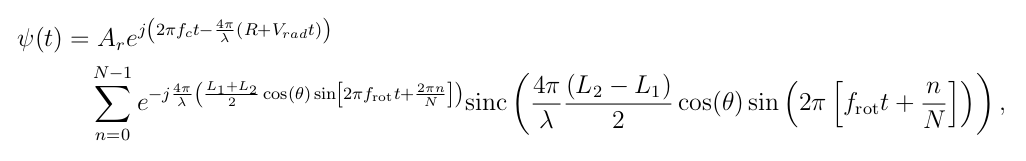

$\psi$ is just a function of a single variable $t$, but it returns a complex number. For this task, we will only be considering the real component of the output.

I've created a builder function called `psigenerator`, which builds us a psi function given all the radar parameters. I also have a config file for storing parameters, to give them names. Combining these two elements gives us $\psi(t)$.

In [1]:
from signalgenerator import psigenerator
from configurations import paperconfig1, paperconfig2

In [2]:
psi1 = psigenerator(**paperconfig1)  # our psi(t)
psi2 = psigenerator(**paperconfig2)

I have another helper function called generate data, which takes a function like psi, a sampling frequency, and 
a sample length, and returns the resulting data points:

In [3]:
from signalgenerator import generateData

xs1, ys1 = generateData(psi1, f_s=50_000, sample_length=0.05)
xs2, ys2 = generateData(psi2, f_s=50_000, sample_length=0.05)

Let's plot our generated data:

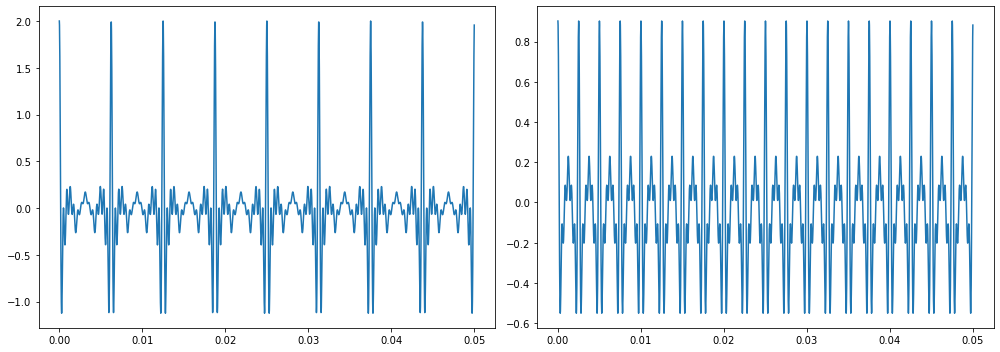

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axes[0].plot(xs1, ys1)
axes[1].plot(xs2, ys2)
fig.tight_layout()

The plots above are consistent with the examples in https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=201091. Same parameters, same waveforms:
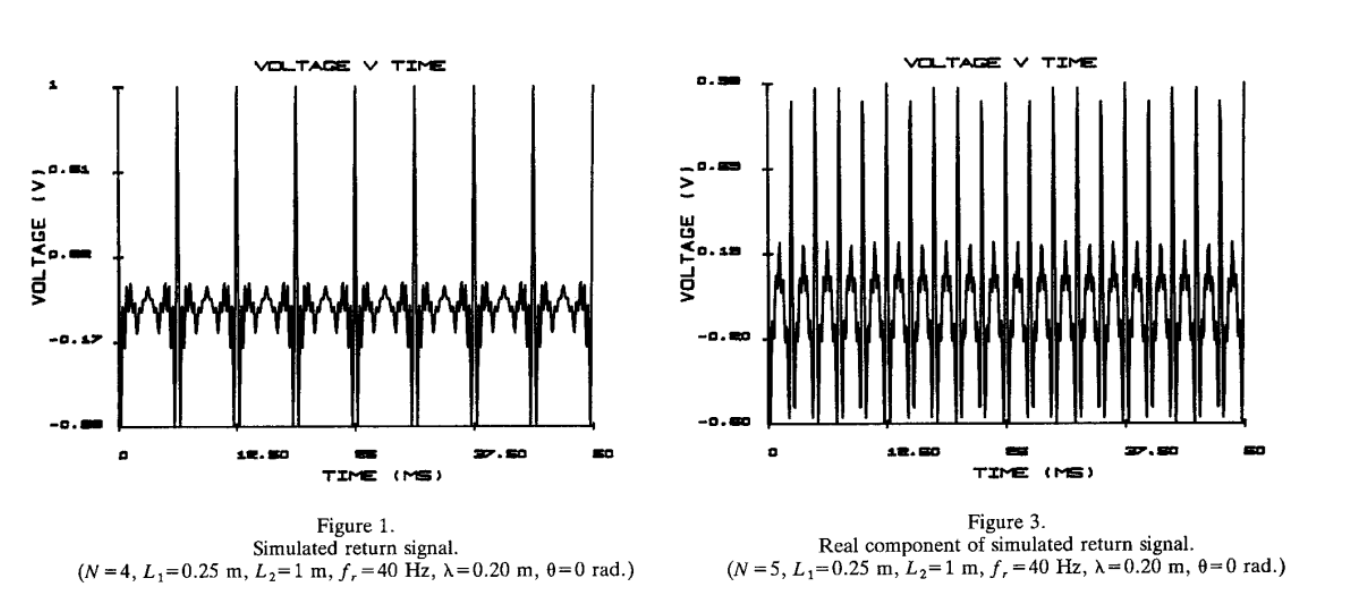


If you would like to see the messy code that is actually $\psi(t)$, go to `signalgenerator.py`.

Next, we should plot the Short-window and long window Fourier transforms. Again, I have a helper function to plot , so that this jupyter notebook isn't too long. You can find this function in `fourier.py`.

/home/sinclair/Documents/CANSOFCOM/fourier.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(t, np.fft.fftshift(f), 20*np.log10(np.abs(np.fft.fftshift(Zxx, axes=0))))
/home/sinclair/Documents/CANSOFCOM/fourier.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[2].pcolormesh(t, np.fft.fftshift(f), 20*np.log10(np.abs(np.fft.fftshift(Zxx, axes=0))))


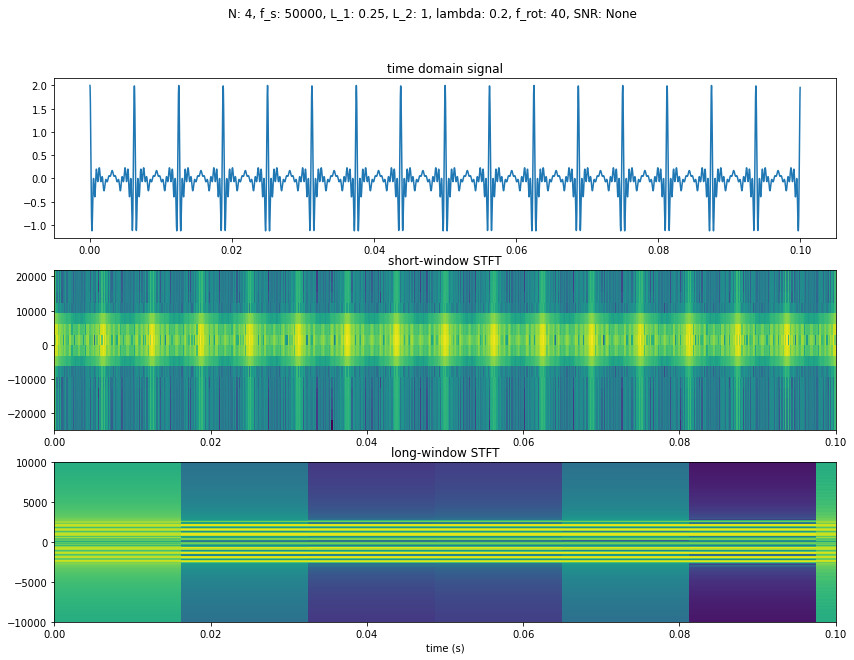

In [5]:
from fourier import plotSTFT

xs1, ys1 = generateData(psi1, f_s=50_000, sample_length=0.1)  # generate more data. 50ms isn't great for fourier
plotSTFT(xs1, ys1, 50_000, paperconfig1)

Note the MERN lines in the Long-window STFT. The short-window STFT is periodic because of the rotation of the propellors. The micro-doppler effect of the propellors can be seen better in the next example, where there are 2 propellors and they're slower. For this, I'll use a configuration inspired by the Parrot Disco; a commercially available drone I'll be using in later steps.

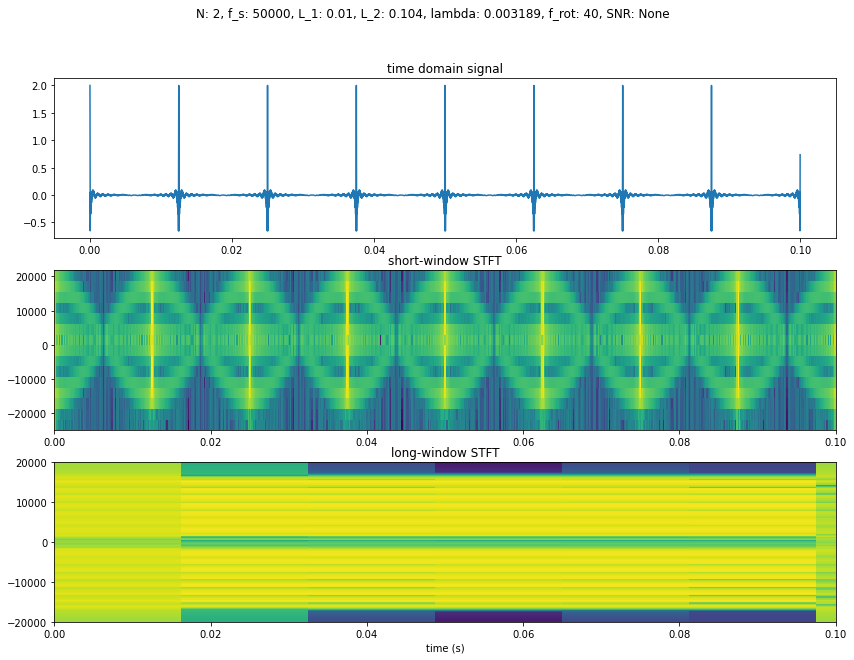

{'R': 0,
 'V_rad': 0,
 'A_r': 1,
 'lamb': 0.003189,
 'theta': 0,
 'f_c': 94010661649.41988,
 'SNR': None,
 'name': 'Parrot_Disco',
 'N': 2,
 'L_1': 0.01,
 'L_2': 0.104,
 'f_rot': 40}

In [6]:
from configurations import scenarioWband, parrotdisco
conf = dict(scenarioWband, **parrotdisco)
realpsi = psigenerator(**conf)
xs1, ys1 = generateData(realpsi, f_s=50_000, sample_length=0.1)
plotSTFT(xs1, ys1, 50_000, conf, size=20_000)
conf

Above, you can clearly see the micro-doppler effect of the spinning propellors; a symmetric saw-tooth pattern in the short window. As the radio waves hit the propellor, the propellor moves _into_ them, shortening the wavelength and increasing the frequency. That's why we see the waves of higher frequency signals.

# 2 Simulate Radar Returns from Drones

Our `psigenerator` function has a parameter for noise. So we simply create a noisy function, generate the data, and then plot the fourier transforms. We'll use configurations that I've set up to mimic the wavelengths of X-band (10GHz) and W-band (94 GHz), and with the properties of real drones. We'll also switch to the convention of using **10kHz** as a sampling frequency for X-band, and **26kHz** for a sampling frequency of W-band. These values are realistic, and will be used later on. I'm also going to be plotting with no noise, to get a baseline for these plots.

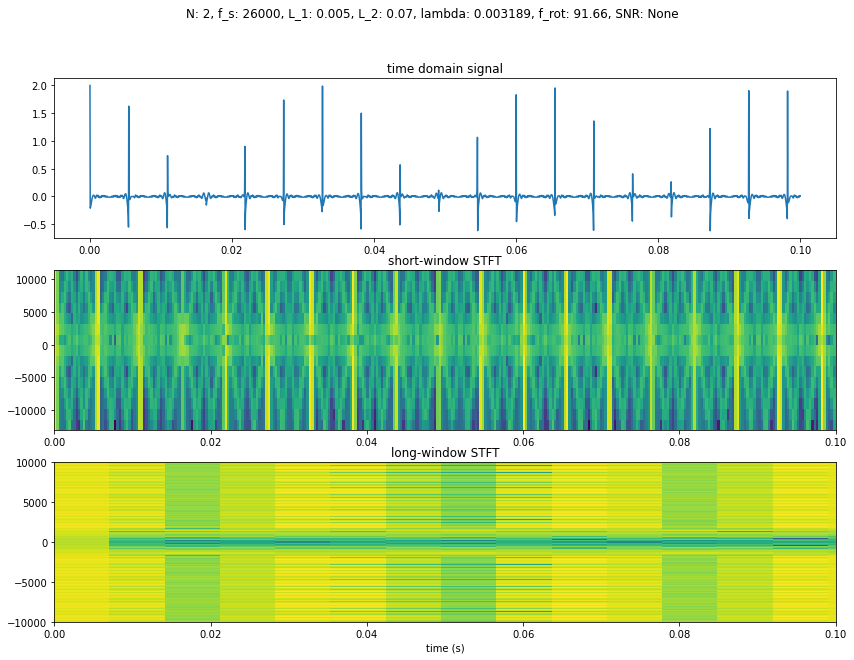

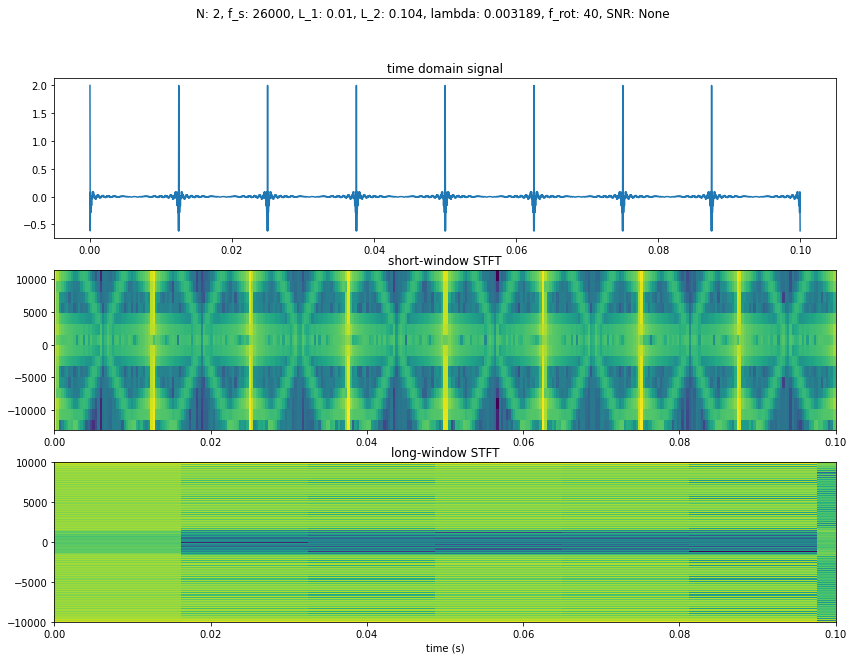

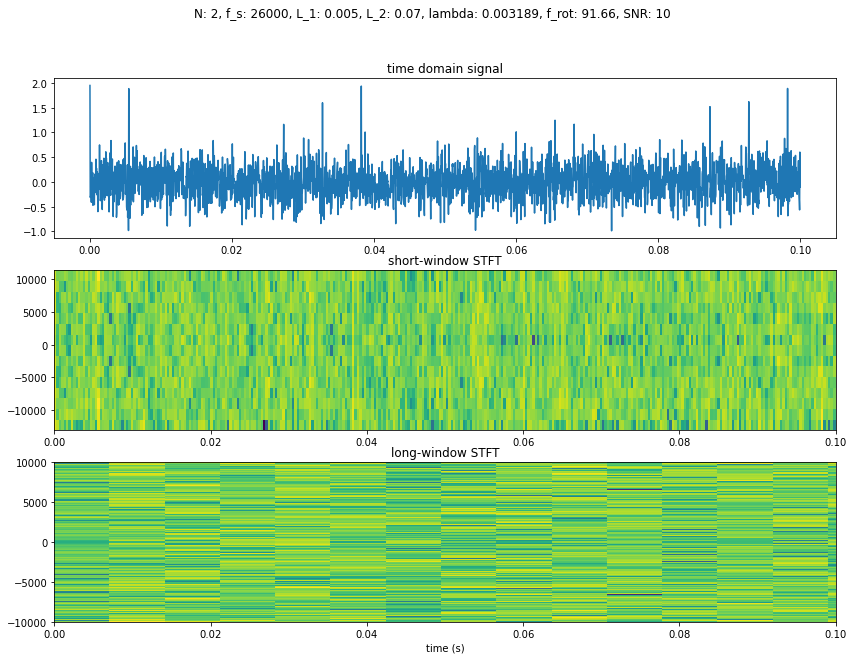

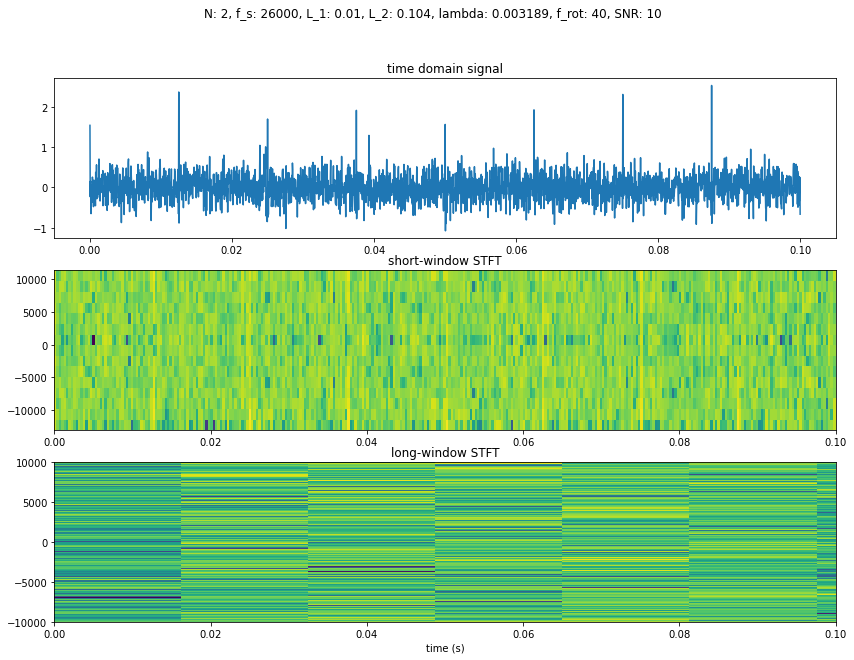

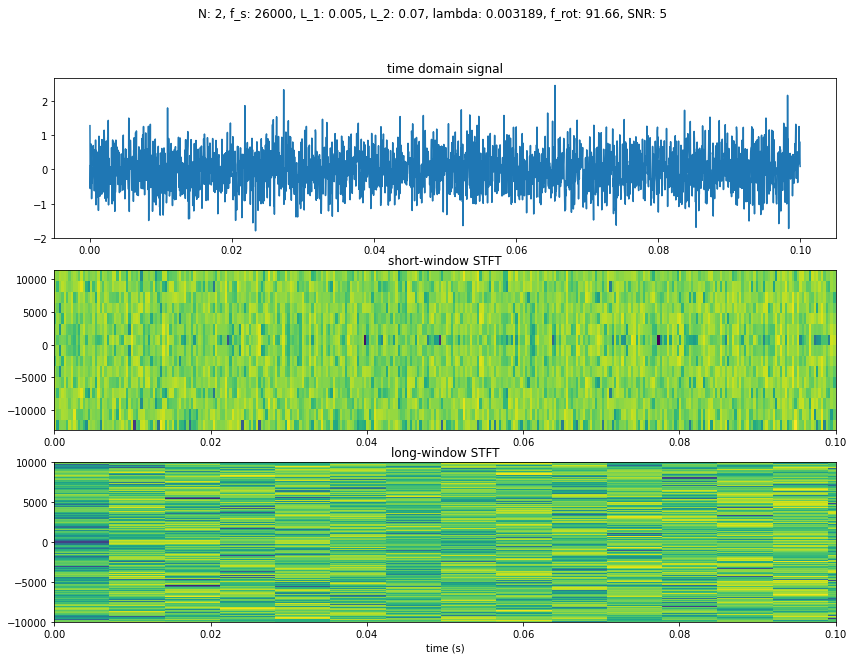

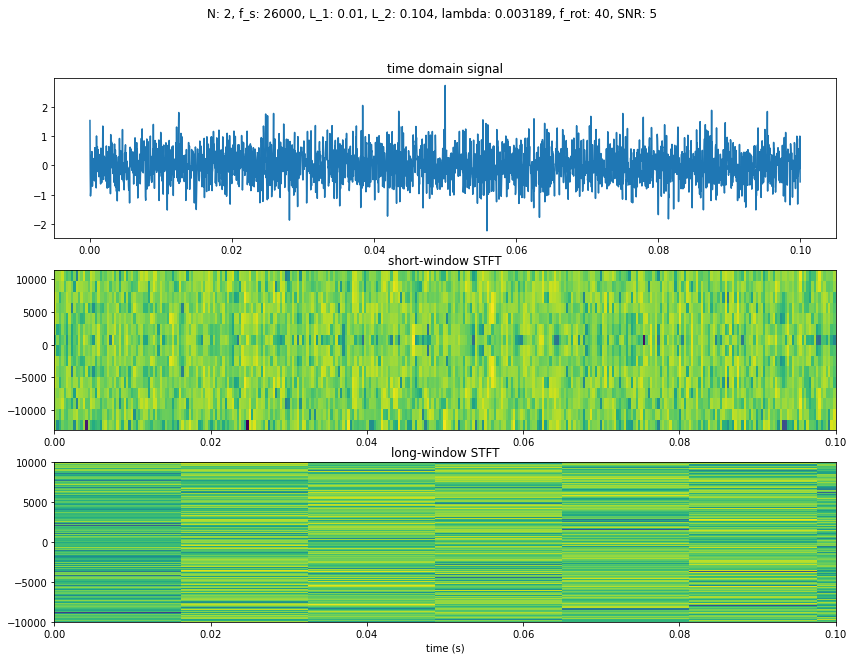

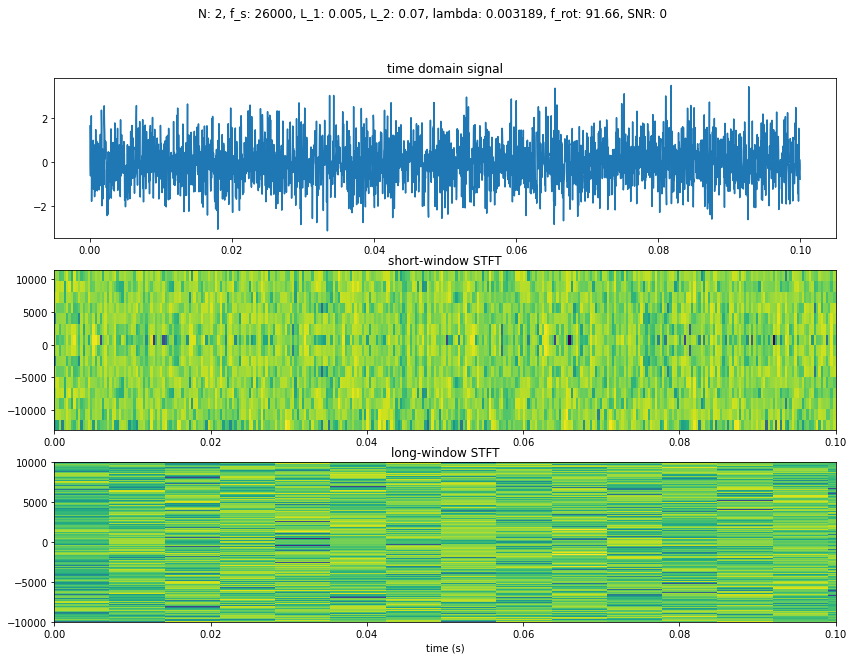

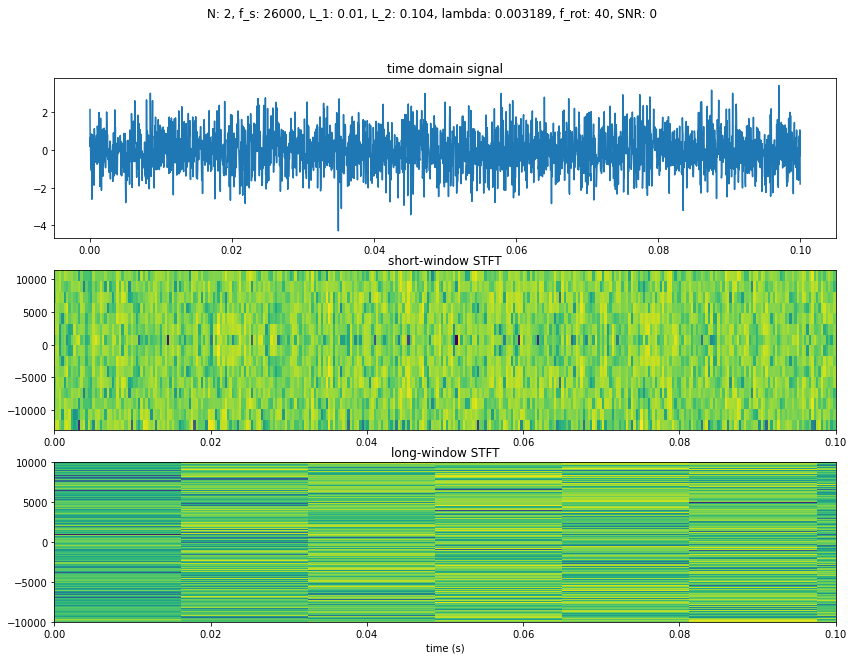

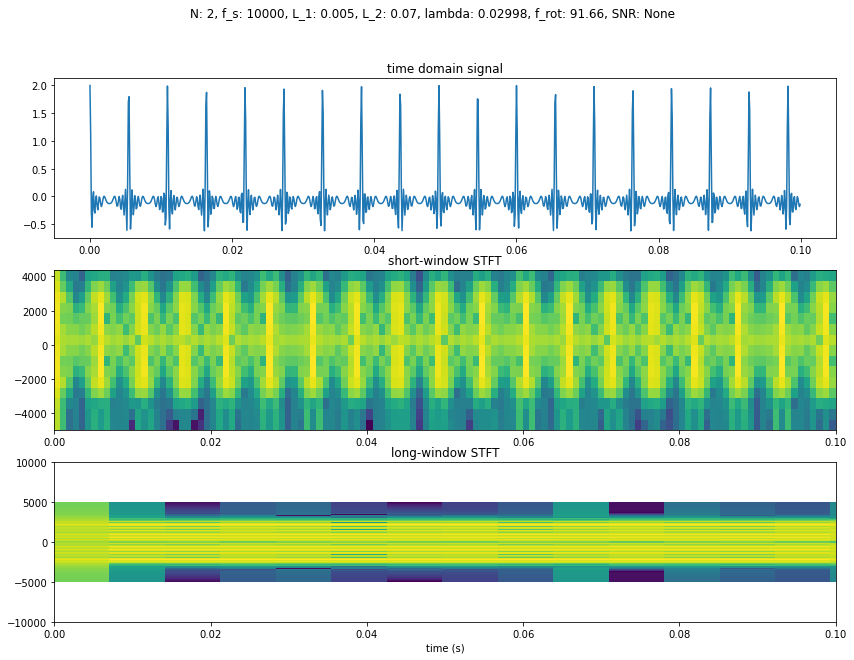

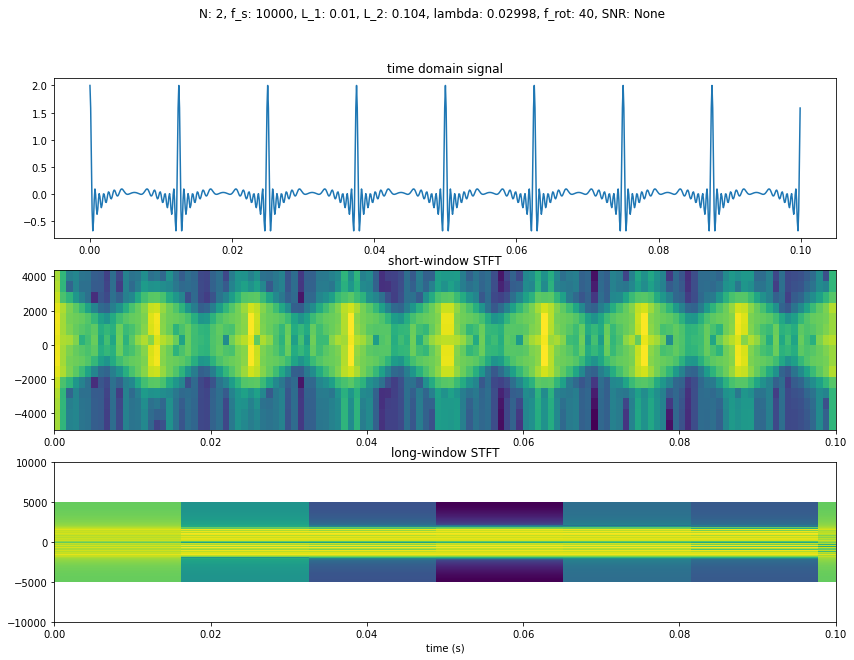

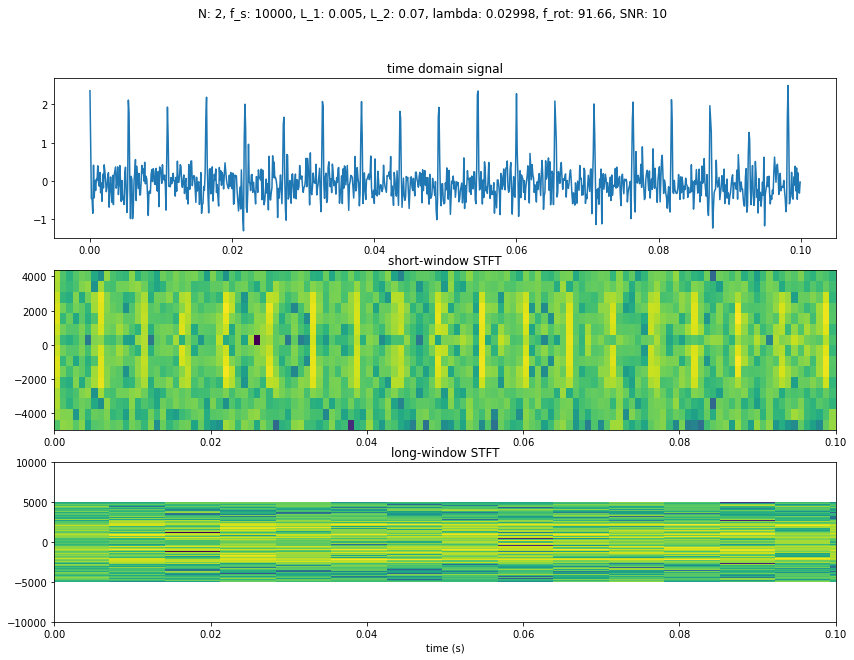

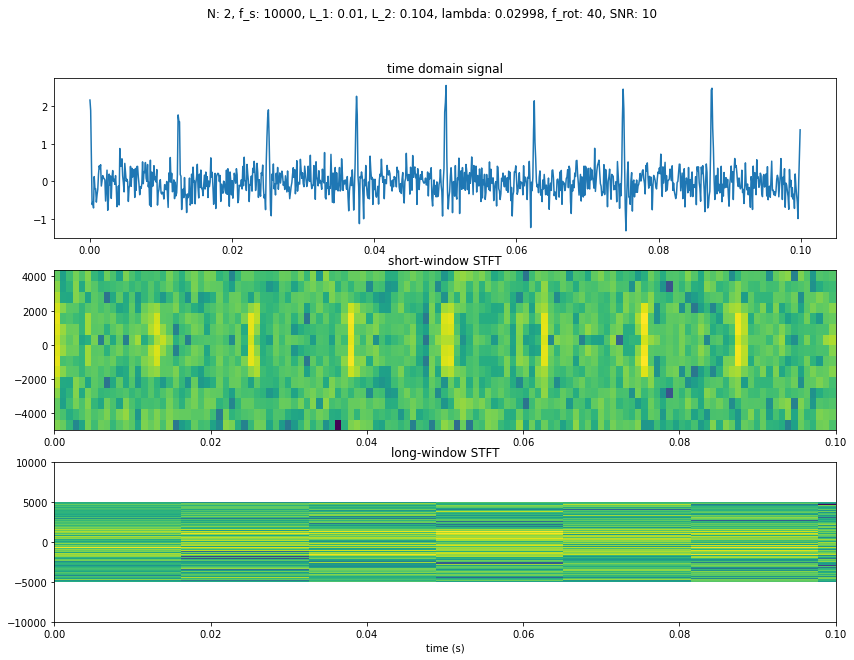

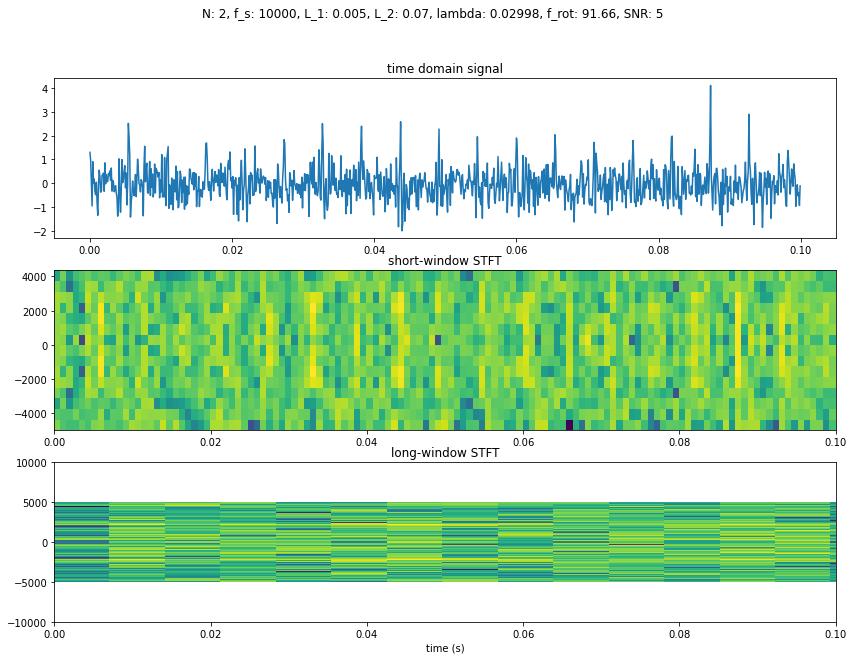

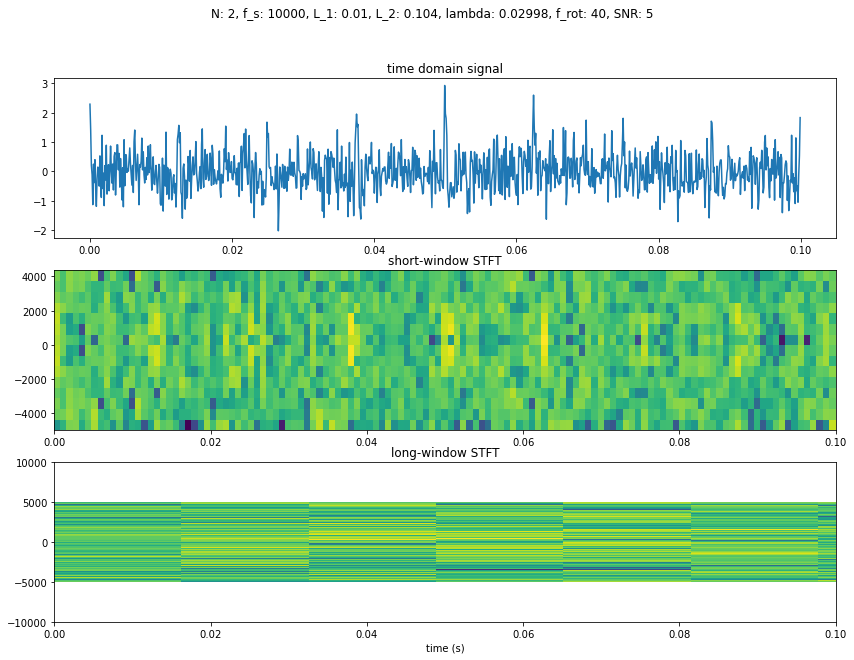

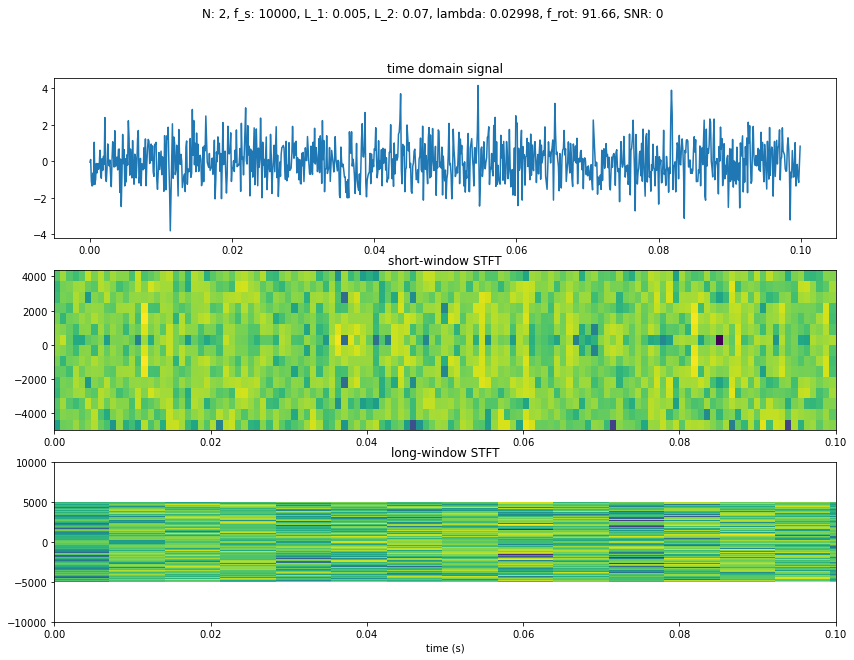

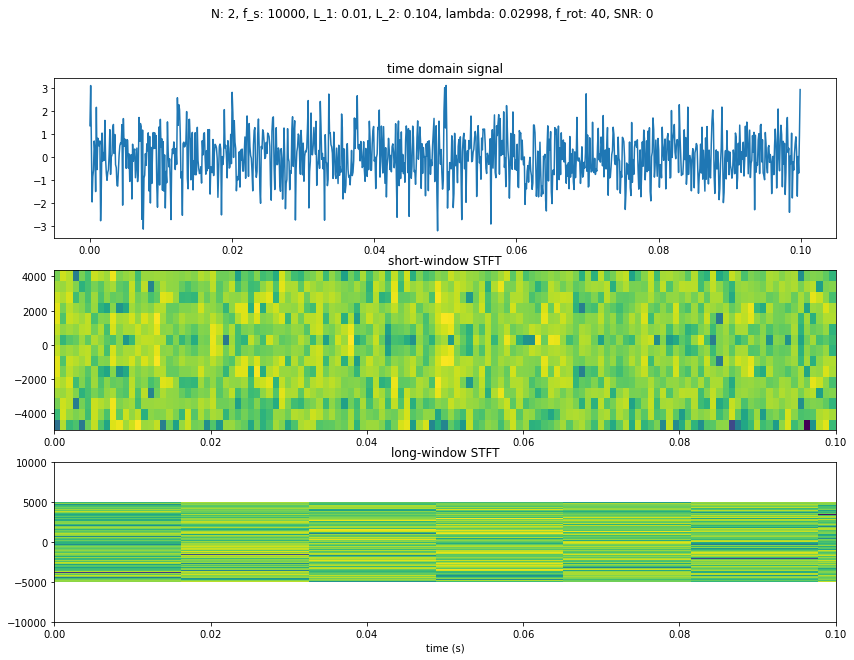

In [7]:
from configurations import scenarioWband, scenarioXband, djimavicair2, parrotdisco

for f_s in [26_000, 10_000]:
    for SNR in [None, 10, 5, 0]:  # 10 is the least noisy, 0 is the most noisy
        scenario = {}
        if f_s == 26_000:
            scenario = scenarioWband
        else:
            scenario = scenarioXband
        conf1 = dict(scenario, **djimavicair2)
        conf2 = dict(scenario, **parrotdisco)
        conf1["SNR"] = SNR
        conf2["SNR"] = SNR
        psi1 = psigenerator(**conf1)
        psi2 = psigenerator(**conf2)

        x1, y1 = generateData(psi1, f_s, 0.1)
        x2, y2 = generateData(psi2, f_s, 0.1)

        plotSTFT(x1, y1, f_s, conf1)
        plotSTFT(x2, y2, f_s, conf2)


## When looking at the plots above, look at their titles to see their parameters!!

As you can see above, the noise really affects the fourier transforms, especially at high frequencies. It's very noisy. However, there are still patterns in these plots, and if I can see the patterns, a neural network can see the patterns.

# 3 Prepare Data Sets

I've chosen **5** drones for classification, and pulled their parameters from sources, or estimated them. See the details in `configurations.py`, at the bottom. 5 drones is more than 4, qualifying for bonus!
* DJI Mavic Mini
* DJI Phantom 4
* DJI Mavic Air 2
* DJI Matrice 300 RTK
* Parrot Disco

I'm not going to run the dataset generation here; it takes a while. For details, see `dataset_generation.py`. The code actually looks very similar to the previous code block; I'm just looping through the radar frequencies, SNRs, and drones, and saving the **short-window STFTs**. I think this data is very rich; it contains a lot of distinctive patterns. My sample length is 0.15 seconds, which is small enough to be usable. Per drone per frequency per SNR for training, I have 5_000 examples for training, and 1_000 for testing. 

# 4 Machine Learning

I chose to apply a simple **convolutional network** to the short window STFTs. 
The patterns have local and global features, so it seemed like the best choice. They're also fast to run and easy to train. I'm working in **PyTorch**, and I'm using my **GPU** for training and evaluation, an Nvidia GTX 1070.

I use a different classifier for X-Band and W-Band, because the inputs are of different scales; the features will be different. Both architectures are super small and fast; they're similar. I designed them in a way to be adverse to noise; I use layer normalization and a lot of dropout. That makes them trickier to train, but when they're all trained they perform very well, even at low SNRs.

Check out my training script `train.py` for specifics.
also check out my [Weights and Biases](https://wandb.ai/sinclairhudson/cansofcom) control board. It's how I keep track of my training runs.

At the end of any training run, I save the model parameters with a smart name. I've committed all the saves to the github repo, so that this last section can be run.

In [ ]:
class_map = ["DJI_Matrice_300_RTK", "DJI_Mavic_Air_2",
             "DJI_Mavic_Mini", "DJI_Phantom_4", "Parrot_Disco"]
# when you see class 0, it's the Matrice,
# when you see class 1, it's the Mavic Air,
# ...

In [ ]:
from test import test_classifier
test_classifier(f_s=26000, SNR=5)